In [16]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import config
import csv
from torch.utils.data import random_split
from PIL import Image
import torch

In [18]:
class JetbotDataset(Dataset):
    def __init__(self, image_dir, csv_path, image_size, num_prev_frames, transform=None):
        self.image_dir = image_dir
        self.csv_path = csv_path
        self.image_size = image_size
        self.transform = transform
        self.num_prev_frames = num_prev_frames
        self.image_paths, self.actions = self.load_data()
        self.image_paths = self.image_paths[self.num_prev_frames:]
        self.actions = self.actions[self.num_prev_frames:]


    def load_data(self):
        image_paths = []
        actions = []
        with open(self.csv_path, 'r') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                image_paths.append(row['image_path'])
                actions.append(float(row['action']))
        return image_paths, actions

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        current_image_path = self.image_paths[idx]
        current_image = Image.open(current_image_path).convert("RGB")
        current_action = self.actions[idx]

        prev_frames = []
        for i in range(self.num_prev_frames):
            prev_image_path = self.image_paths[idx - (self.num_prev_frames - i)]
            prev_image = Image.open(prev_image_path).convert("RGB")
            if self.transform:
                prev_image = self.transform(prev_image)
            prev_frames.append(prev_image)

        if self.transform:
            current_image = self.transform(current_image)

        prev_frames_tensor = torch.cat(prev_frames, dim=0)

        return current_image, torch.tensor([current_action], dtype=torch.float32), prev_frames_tensor

def save_existing_split(train_dataset, test_dataset, filename="dataset_split.pth"):
    """Saves the indices of existing Subset objects to a file.

    Args:
        train_dataset: The Subset object representing the training set.
        test_dataset: The Subset object representing the test set.
        filename: The name of the file to save the indices to.
    """

    # Check if they are actually Subset objects.  Important!
    if not isinstance(train_dataset, Subset) or not isinstance(test_dataset, Subset):
        raise TypeError("Both train_dataset and test_dataset must be Subset objects.")

    # Extract the indices. This is the key step.
    train_indices = train_dataset.indices
    test_indices = test_dataset.indices

    # Combine them into a single list (or tuple) for saving.
    all_indices = [train_indices, test_indices]

    # Save the indices using torch.save
    torch.save(all_indices, os.path.join(config.OUTPUT_DIR, filename))

def load_train_test_split(dataset, filename="dataset_split.pth"):
    """Loads the indices of existing Subset objects from a file."""

    filepath = os.path.join(config.OUTPUT_DIR, filename)
    if not os.path.exists(filepath):
        return None, None # Return None if file does not exist

    splits = torch.load(filepath)
    return tuple(Subset(dataset, indices) for indices in splits)

def display_dataset_entry(dataset_entry):
    frame,action,previous_frames = dataset_entry
    print(f'Action: {action}')
    print('Current Frame:')
    display_frame(frame)
    print('Previous Frames:')
    for i in range(config.NUM_PREV_FRAMES):
        
        frame = previous_frames[(i * 3):(i + 1) * 3, :, :]  # Extract each frame (C, H, W)
        display_frame(frame)


def display_frame(frame):
    frame = (frame.clamp(-1, 1) + 1) / 2 # Unnormalize
    frame = (frame * 255).type(torch.uint8) # To uint8
    display(transforms.ToPILImage()(frame))



Action: tensor([0.1000])
Current Frame:


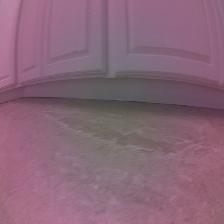

Previous Frames:


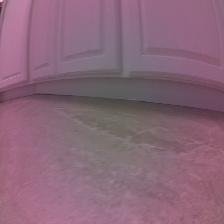

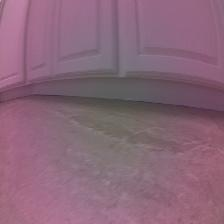

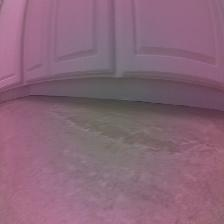

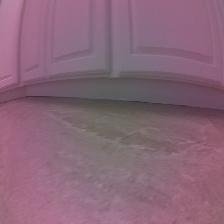

In [20]:
if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    dataset = JetbotDataset(config.IMAGE_DIR, config.CSV_PATH, config.IMAGE_SIZE, config.NUM_PREV_FRAMES, transform=transform)
    
    train_size = int(0.8 * len(dataset))  # 80% for training
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    display_dataset_entry(test_dataset[40])